In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import constants
import IPython.display as ipd  # To play sound in the notebook
np.random.seed(1001)
import os
from os import listdir
from os.path import isfile, join
import shutil
import IPython
import matplotlib
import seaborn as sns
from scipy.io import wavfile

<b> Training data </b>

In [2]:
data_loc="database/"
wav_path = data_loc+"audio_train/"
sr=44100

In [3]:
dataset = pd.read_csv(data_loc+"train.csv",header=0,names=['fname','label','verified'])
checkedDataset = dataset.loc[dataset.verified == 1,["fname","label"]]

In [5]:
# Based on https://www.kaggle.com/codename007/a-very-extensive-freesound-exploratory-analysis?scriptVersionId=3019309
def load_wav_file(name):
    _, b = wavfile.read(wav_path + name)
    assert _ == sr
    return b

checkedDataset['time_series'] = checkedDataset['fname'].apply(load_wav_file)
checkedDataset['nframes'] = checkedDataset['time_series'].apply(len)

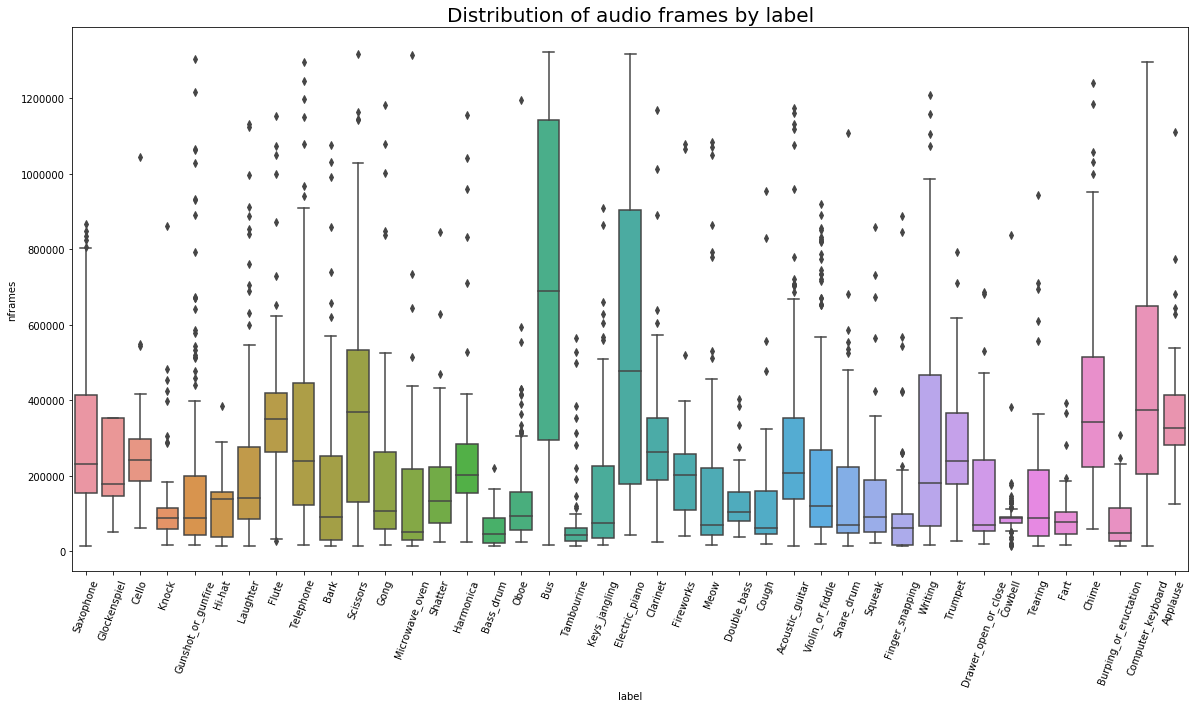

In [5]:
# Lets look at the distribution of audio frames for each label
# Idea also based on above mentioned notebook

plt.figure(figsize=(20,10))
plt.ylabel="Label"
plt.xlabel='Num Frames'
sns.boxplot(x='label', y='nframes', data=checkedDataset)
plt.xticks(rotation=70)
plt.title('Distribution of audio frames by label', fontsize=20)
plt.show()

In [6]:
# Max Y val (frames) is 2584, min is 28
# Normalization function
def normalize(df):
    return (df - df.mean(axis=0)) / (df.std(axis=0))

# Returns normalized mfcc dataset
def getData(df, train=True):
    dset=[]
    audiolen=2*sr
    
    if train==False:
        ddir=data_loc+"audio_test/"
        files=[f for f in listdir(ddir) if isfile(join(ddir, f))]
#         files=[f for f in listdir(ddir)]
    else:
        ddir=wav_path
        files=df.fname.values
    
    for file in files:
        wav,_= librosa.core.load(ddir+file, sr=sr)
        
        # Pad/trim WAV data
        if len(wav) > audiolen:
            wav = wav[:audiolen]
        elif len(wav) < audiolen:
            off=audiolen - len(wav) 
            wav=np.pad(wav, (off, audiolen - len(wav) - off), 'constant')
            
        mfcc = librosa.feature.mfcc(wav, sr = sr, n_mfcc=40)
        dset.append(mfcc)
    
    return (normalize(np.array(dset))) # Return normalized dataset

In [7]:
xtrain=getData(checkedDataset)

In [8]:
# Get test data
xtest=getData(None, False)

<b>Data encoding and splitting</b>

In [7]:
# We have labels as categories, need to convert these to one-hot!
# First, convert to integers
from sklearn import preprocessing

def encode(data, oneHot=False):
    # Encode labels into integers or onehot
    le = preprocessing.LabelEncoder()
    le.fit(data)
    trans = le.transform(data)
    if oneHot== True:
        ohlen = (len(set(trans)))
        eye=np.eye(ohlen)
        return np.array([eye[i] for i in trans])
    else:
        return trans

In [10]:
yt=encode(checkedDataset.label.values, oneHot=True)
# print (yt.shape)

In [8]:
def tvsplit(x,y,keep):
    # trainsz - size of train set to retain; eg 0.7
    trsize=int(x.shape[0] * keep)

    x_train=x[:trsize]
    x_val=x[trsize:] 

    y_train=y[:trsize] 
    y_val=y[trsize:] 
    
    return x_train,x_val,y_train,y_val

In [12]:
# Get validation set - keep 70% for train, 15% validation, 15% test

'''
FIX THIS - we already got x_test above!! Losing data here..
'''

# Size of splits
trsize=int(xtrain.shape[0] * 0.7)
valsize=int((xtrain.shape[0] - trsize) * .5)

# X 
x_train=xtrain[:trsize] # shape (2968, 40, 28)
x_val=xtrain[trsize:trsize+valsize] # shape (742, 40, 28)
x_test=xtrain[trsize+valsize:]
# Labels
y_train=yt[:trsize] # shape 2968, 41
y_val=yt[trsize:trsize+valsize] # shape 742, 41
y_test=yt[trsize+valsize:]

print ('Train sizes:')
print (x_train.shape)
print (y_train.shape)

print ('\nValidation sizes:')
print (x_val.shape)
print (y_val.shape)

print ('\nTest sizes:')
print (x_test.shape)
print (y_test.shape)

Train sizes:
(2597, 40, 173)
(2597, 41)

Validation sizes:
(556, 40, 173)
(556, 41)

Test sizes:
(557, 40, 173)
(557, 41)


<b>Classification</b>

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding, BatchNormalization

/var/kennys_files/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
model = Sequential([
    LSTM(28, return_sequences=True, input_shape=(40,173)),
    Dense(173, activation='relu'),
    BatchNormalization(),
    LSTM(173),
    BatchNormalization(),
    Dense(41, activation='softmax')
    
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 28)            22624     
_________________________________________________________________
dense_1 (Dense)              (None, 40, 173)           5017      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 173)           692       
_________________________________________________________________
lstm_2 (LSTM)                (None, 173)               240124    
_________________________________________________________________
batch_normalization_2 (Batch (None, 173)               692       
_________________________________________________________________
dense_2 (Dense)              (None, 41)                7134      
Total params: 276,283
Trainable params: 275,591
Non-trainable params: 692
_________________________________________________________________
No

In [15]:
# model.fit(x_train, y_train,
#           batch_size=48, epochs=300,
#           validation_data=(x_val, y_val))

In [16]:
# score = model.evaluate(x_test, y_test, batch_size=128)
# print(score)

In [10]:
# Lets try and create a better model
from keras.layers import (Convolution1D, GlobalAveragePooling1D, BatchNormalization, Flatten,
                          GlobalMaxPool1D, MaxPool1D, Flatten, concatenate, Activation)
from keras.utils import Sequence, to_categorical

In [18]:
m2 = Sequential([
    Convolution1D(28,4, padding="same", input_shape=(x_train.shape[1], x_train.shape[2]),\
                 activation='relu'),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(28,4, padding="same"),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(28,4, padding="same"),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(28,4, padding="same"),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(rate=0.1),
    
#     Dense(28, activation='relu'),
    Dense(41, activation='softmax')
])
m2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print (m2.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 28)            19404     
_________________________________________________________________
batch_normalization_3 (Batch (None, 40, 28)            112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 28)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 28)            3164      
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 28)            112       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 28)             0         
___________________________________________________________

In [19]:
# m2.fit(x_train, y_train,
#           batch_size=48, epochs=150,
#           validation_data=(x_val, y_val))

In [20]:
# score2 = m2.evaluate(x_test, y_test, batch_size=128)
# print(score2)

<b> Melspectrogram convnet </b>

In [11]:
# First, get melspectrogram
from librosa.feature import melspectrogram

In [12]:
def melspec(df, train=True):
    dset=[]
    audiolen=2*sr
    
    if train==False:
        ddir=data_loc+"audio_test/"
        files=[f for f in listdir(ddir) if isfile(join(ddir, f))]
    else:
        ddir=wav_path
        files=df.fname.values
    
    for file in files:
        wav,_= librosa.core.load(ddir+file, sr=sr)
        
        # Pad/trim WAV data
        if len(wav) > audiolen:
            wav = wav[:audiolen]
        elif len(wav) < audiolen:
            off=audiolen - len(wav) 
            wav=np.pad(wav, (off, audiolen - len(wav) - off), 'constant')
            
        ms = melspectrogram(wav, sr = sr)
        dset.append(ms)
    
    return (normalize(np.array(dset))) # Return normalized dataset

In [13]:
xtrainms=melspec(checkedDataset)

In [15]:
xtestms=melspec(None, False)

In [25]:
print(np.vstack(xtrainms).shape)

(474880, 173)


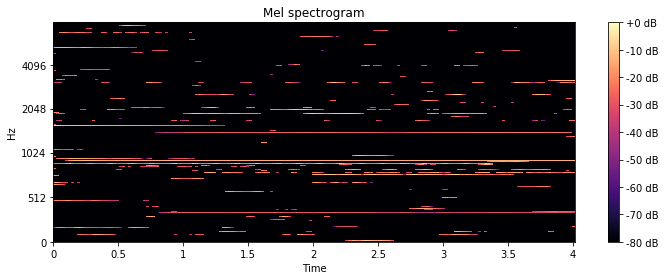

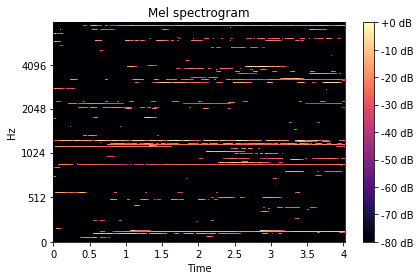

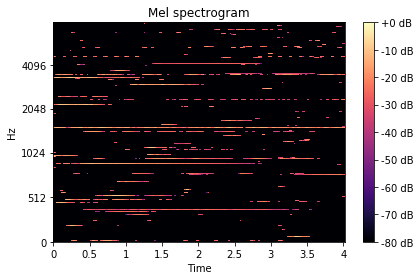

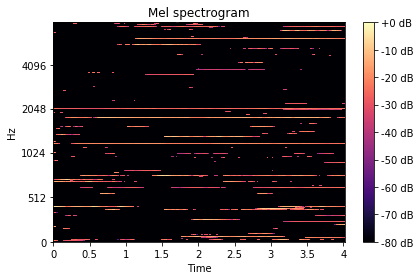

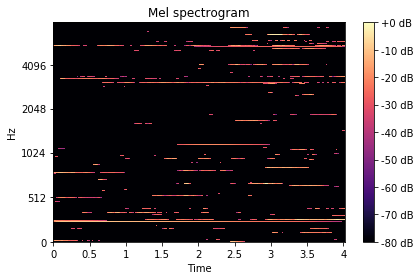

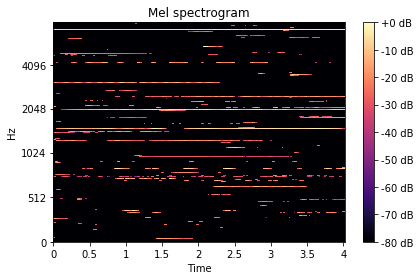

ValueError: zero-size array to reduction operation maximum which has no identity

In [26]:
# How do the waves look?
import librosa.display
plt.figure(figsize=(10, 4))
xplt=np.vstack(xtrainms)
size=xplt.shape[0] % 80000
for i in range(0,size):
    start=i*80000
    stop=(i+1)*80000
    if i == size-1:
        stop = xplt.shape[0]
    librosa.display.specshow(librosa.power_to_db(xplt[start:stop], ref=np.max),
                             y_axis='mel', x_axis='time', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

In [16]:
yt=encode(checkedDataset.label.values, oneHot=True)

In [17]:
xtrms,xvalms,ytrms,yvalms = tvsplit(xtrainms,yt, 0.85)
xvalcn, xtestcn, yvalcn, ytestcn = tvsplit(xvalms, yvalms, 0.5)

In [63]:
print (xtrainms.shape)
print (xtrms.shape)
print (xvalcn.shape)
print (yt.shape)
print('\n')
print (ytrms.shape)
print (yvalcn.shape)
print (yvalms.shape)

(3710, 128, 173)
(3153, 128, 173)
(278, 128, 173)
(3710, 41)


(3153, 41)
(279, 128, 173)
(557, 41)


In [25]:
# Design conv net
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

cnet = Sequential([
    Convolution1D(28,4, padding="same", input_shape=(xtrms.shape[1], xtrms.shape[2]),\
                 activation='relu'),
    BatchNormalization(),
    MaxPool1D(1),
    
    Convolution1D(28,4, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool1D(1),
    
    Convolution1D(28,4, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(28,4, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(28,4, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(28,4, padding="same", activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(rate=0.5),

    Dense(41, activation='softmax')
])

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.0001)

early = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10,\
                      verbose=0, mode='auto', baseline=None)

cnet.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

print (cnet.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 128, 28)           19404     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 28)           112       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 128, 28)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 128, 28)           3164      
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 28)           112       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 128, 28)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 128, 28)           3164      
__________

In [30]:
cnet.fit(xtrms, ytrms,
          batch_size=23, epochs=500,
          validation_data=(xvalcn, yvalcn),
          callbacks=[early, lr_reduction])

Train on 3153 samples, validate on 278 samples
Epoch 1/500
3153/3153 [==============================] - 5s 1ms/step - loss: 1.0198 - acc: 0.6971 - val_loss: 1.8686 - val_acc: 0.5108
Epoch 2/500
3153/3153 [==============================] - 4s 1ms/step - loss: 1.0511 - acc: 0.6901 - val_loss: 1.8734 - val_acc: 0.5216
Epoch 3/500
3153/3153 [==============================] - 4s 1ms/step - loss: 1.0270 - acc: 0.6974 - val_loss: 1.8638 - val_acc: 0.5000
Epoch 4/500
3153/3153 [==============================] - 4s 1ms/step - loss: 1.0193 - acc: 0.6952 - val_loss: 1.8624 - val_acc: 0.5072
Epoch 5/500
3153/3153 [==============================] - 3s 946us/step - loss: 1.0254 - acc: 0.6968 - val_loss: 1.8599 - val_acc: 0.5036
Epoch 6/500
3153/3153 [==============================] - 3s 1ms/step - loss: 1.0056 - acc: 0.6962 - val_loss: 1.8498 - val_acc: 0.5180
Epoch 7/500
3153/3153 [==============================] - 4s 1ms/step - loss: 1.0284 - acc: 0.6993 - val_loss: 1.8683 - val_acc: 0.5072
Epoch 

In [31]:
cnetscore = cnet.evaluate(xtestcn, ytestcn, batch_size=128)

print(cnetscore)

279/279 [==============================] - 0s 473us/step
[1.900758129721474, 0.5268817201096524]
